<a href="https://colab.research.google.com/github/colleenrpy/MONAI_handson/blob/main/MONAI_Transforms_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.8.1"

     |████████████████████████████████| 721 kB 2.1 MB/s 
     |████████████████████████████████| 251 kB 61.3 MB/s 


**Enabling GPU Support**

To use GPU resources through Colab, change the runtime to GPU:

1. From the "Runtime" menu select "Change Runtime Type"
2. Choose "GPU" from the drop-down menu
3. Click "SAVE"
This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running

**!nvidia-smi**

in a cell will verify this has worked and show you what kind of hardware you have access to.

In [2]:
!nvidia-smi

Fri Sep 30 01:38:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import monai
import torch
import time

print('monai\'s version:', monai.__version__)
print('torch\'s version:', torch.__version__)

monai's version: 0.8.1
torch's version: 1.12.1+cu113


In [4]:
import gdown
data_folder_gd_url = "https://drive.google.com/drive/folders/1qDXyp_gol5kewj1V00uy2GgzLHsB-D_n?usp=sharing"
gdown.download_folder(data_folder_gd_url, remaining_ok=True)

Retrieving folder list


Retrieving folder 1lYyvIQX53DFx1VhVpzo4AcF9OWVAyfR8 img
Processing file 1pwRJQgmcjyLvwEFaj_Qqlax_LIT_ELPh spleen_3.nii.gz
Retrieving folder 1TnJd6NY0sOvIDjuriVtr7MhRdz79IGt6 seg
Processing file 1b8yxmc0Xp1APEf9RadU1Dxst9OqD7Ona spleen_3.nii.gz
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1pwRJQgmcjyLvwEFaj_Qqlax_LIT_ELPh
To: /content/data/img/spleen_3.nii.gz
100%|██████████| 11.4M/11.4M [00:00<00:00, 36.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b8yxmc0Xp1APEf9RadU1Dxst9OqD7Ona
To: /content/data/seg/spleen_3.nii.gz
100%|██████████| 13.7k/13.7k [00:00<00:00, 21.9MB/s]
Download completed


['/content/data/img/spleen_3.nii.gz', '/content/data/seg/spleen_3.nii.gz']

In [5]:
keys = ['img', 'seg']
data_dir = './data/'
fns = os.listdir(data_dir+'img/')
data = [{key: data_dir+key+'/'+fn for key in keys} for fn in fns]
data

[{'img': './data/img/spleen_3.nii.gz', 'seg': './data/seg/spleen_3.nii.gz'}]

![image.png](attachment:3110df9a-e7c8-4e97-b2c4-cce523030425.png)

## Transforms
- Data I/O
- Pre-processing
- Augmentation
- Post-processing

In [6]:
spatial_size = [128, 128, 16]
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  # Data I/O
                                  monai.transforms.AddChanneld(keys),  # Pre-processing
                                  monai.transforms.EnsureTyped(keys),  # Pre-processing
                                  monai.transforms.NormalizeIntensityd(keys='img'),  # Pre-processing
                                  monai.transforms.Resized(keys, spatial_size=spatial_size, mode=['area', 'nearest']),  # Augmentation
                                  monai.transforms.RandScaleIntensityd(keys, 0.2, prob=0.5),  # Augmentation
                                  monai.transforms.RandFlipd(keys, prob=0.5)])  # Augmentation

trans_original = monai.transforms.Compose([monai.transforms.LoadImaged(keys)])

In [7]:
def plot_trans_imgs(trans1, trans2, data):
    img1 = trans1(data)['img']
    if len(img1.shape)==4:
        img1 = img1[0]
    idx1 = img1.shape[-1]//2
    img2 = trans2(data)['img']
    if len(img2.shape)==4:
        img2 = img2[0]
    idx2 = img2.shape[-1]//2
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(img1[..., idx1], cmap='gray')
    plt.title('Img 1')
    plt.xlabel(str(img1.shape)+', '+str(idx1))
    plt.subplot(122)
    plt.imshow(img2[..., idx2], cmap='gray')
    plt.title('Img 2')
    plt.xlabel(str(img2.shape)+', '+str(idx2))
    plt.show()
    
def plot_trans_imgs_hist(trans1, trans2, data):
    img1 = trans1(data)['img']
    if len(img1.shape)==4:
        img1 = img1[0]
    idx1 = img1.shape[-1]//2
    img2 = trans2(data)['img']
    if len(img2.shape)==4:
        img2 = img2[0]
    idx2 = img2.shape[-1]//2
    
    h = [img1.reshape([-1]), img2.reshape([-1])]
    for i in range(2):
        if type(h[i]) == torch.Tensor:
            h[i] = h[i].numpy()
    
    plt.figure(figsize=(16, 12))
    plt.subplot(221)
    plt.imshow(img1[..., idx1], cmap='gray')
    plt.title('Img 1')
    plt.xlabel(str(img1.shape)+', '+str(idx1))
    plt.subplot(222)
    plt.hist(h[0], bins=30, rwidth=.8)
    plt.title('Img 1')
    plt.xlabel('Mean:'+str(round(h[0].mean(), 4))+', StD:'+str(round(h[0].std(), 4)))
    
    plt.subplot(223)
    plt.imshow(img2[..., idx2], cmap='gray')
    plt.title('Img 2')
    plt.xlabel(str(img2.shape)+', '+str(idx2))
    plt.subplot(224)
    plt.hist(h[1], bins=30, rwidth=.8)
    plt.title('Img 2')
    plt.xlabel('Mean:'+str(round(h[1].mean(), 4))+', StD:'+str(round(h[1].std(), 4)))
    
    plt.show()
    


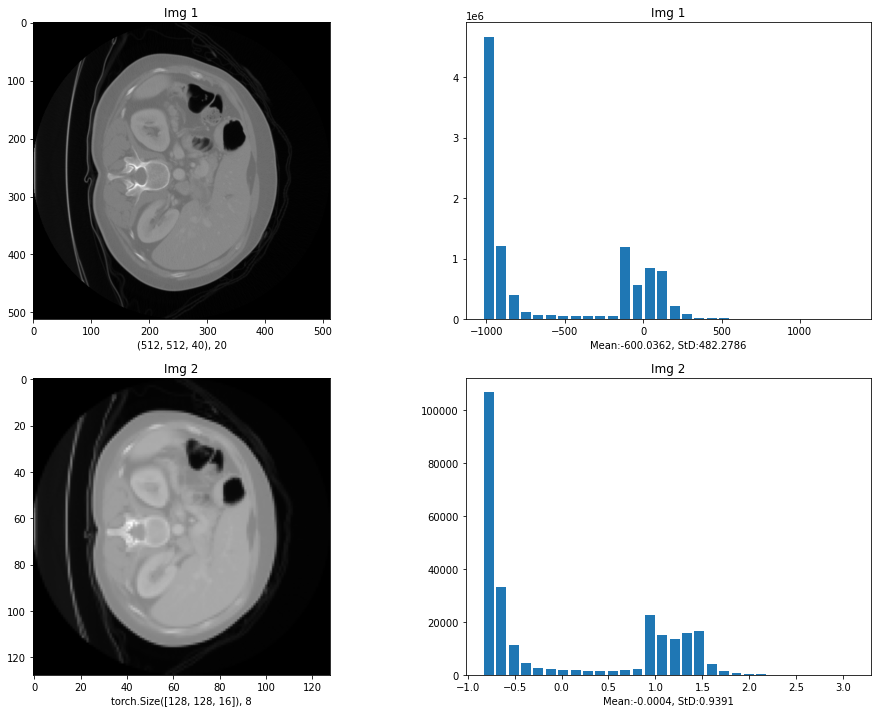

In [8]:
plot_trans_imgs_hist(trans_original, trans, data[0])

#### Customize transforms: Lambda

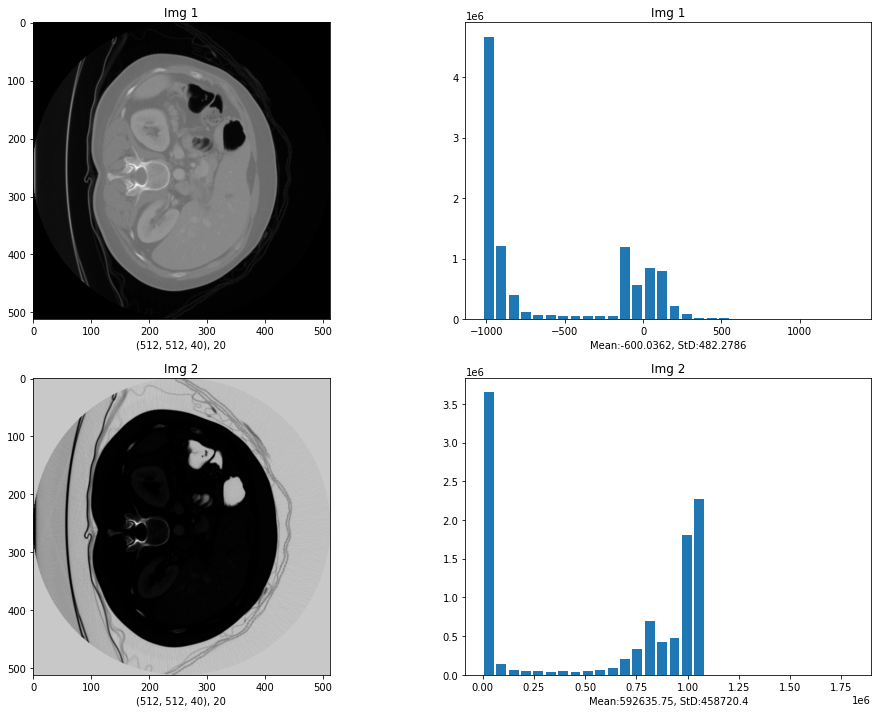

In [9]:
def sqr(img):
    return img**2

trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys, image_only=True), 
                                  monai.transforms.AddChanneld(keys), 
                                  monai.transforms.Lambdad(keys, sqr)])

plot_trans_imgs_hist(trans_original, trans, data[0])

#### Customize transforms: inherit

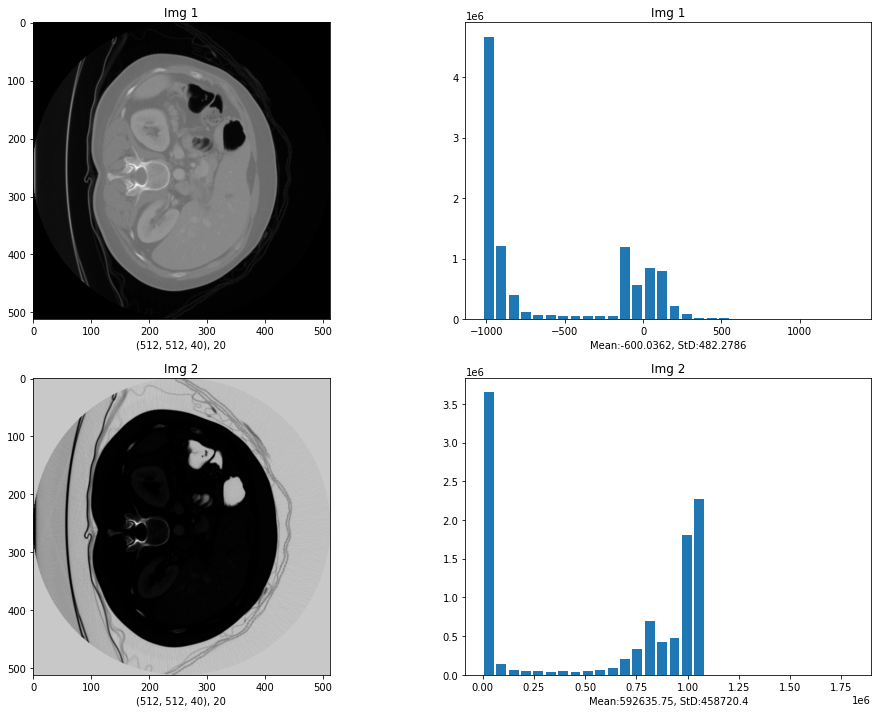

In [10]:
class Sqrd(monai.transforms.MapTransform):
    def __init__(self, params=None):
        self.params = params
        
    def __call__(self, inputs):
        inputs['img'] = inputs['img']**2
        return inputs

trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys, image_only=True), 
                                  monai.transforms.AddChanneld(keys),
                                  Sqrd(keys)])

plot_trans_imgs_hist(trans_original, trans, data[0])

### ***Data I/O***
---
- monai.transforms.LoadImaged
- monai.transforms.SaveImaged

In [11]:
trans_io = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                    monai.transforms.SaveImaged(keys='img',
                                  output_dir='./',
                                  output_postfix='test1',
                                  output_ext='.nii.gz',
                                  separate_folder=False)])
_ = trans_io(data[0])

file written: spleen_3_test1.nii.gz.


### ***Pre-processing***
---

#### Utility
- monai.transforms.AddChanneld
- monai.transforms.EnsureTyped
- monai.transforms.ToTensord

##### **monai.transforms.AddChanneld**
For Conv's matrix computation (channel-first)

In [12]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.AddChanneld(keys),]) 

trans_original(data[0])['img'].shape, trans(data[0])['img'].shape

((512, 512, 40), (1, 512, 512, 40))

##### **monai.transforms.EnsureTyped**
Ensure the input data to be a PyTorch Tensor or numpy array

In [13]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.EnsureTyped(keys, data_type='numpy', dtype=np.float32,),]) 

trans2 = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                   monai.transforms.EnsureTyped(keys)]) 

type(trans_original(data[0])['img']), type(trans(data[0])['img']), type(trans2(data[0])['img'])

(numpy.ndarray, numpy.ndarray, torch.Tensor)

##### **monai.transforms.ToTensord**
Convert the input to a torch tensor. Can also choose target device to put the converted data, such as 'cuda' => put the data into GPU

In [14]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.ToTensord(keys, dtype=torch.float32, device='cuda')]) 

type(trans_original(data[0])['img']), type(trans(data[0])['img']), trans(data[0])['img'].device

(numpy.ndarray, torch.Tensor, device(type='cuda', index=0))

#### Intensity
- monai.transforms.NormalizeIntensityd
- monai.transforms.ScaleIntensityRanged
- monai.transforms.GaussianSmoothd
- monai.transforms.HistogramNormalized

##### **monai.transforms.NormalizeIntensityd**
Normalize input using calculated mean and std by default. You can provide the subtrahend and divisor instead.

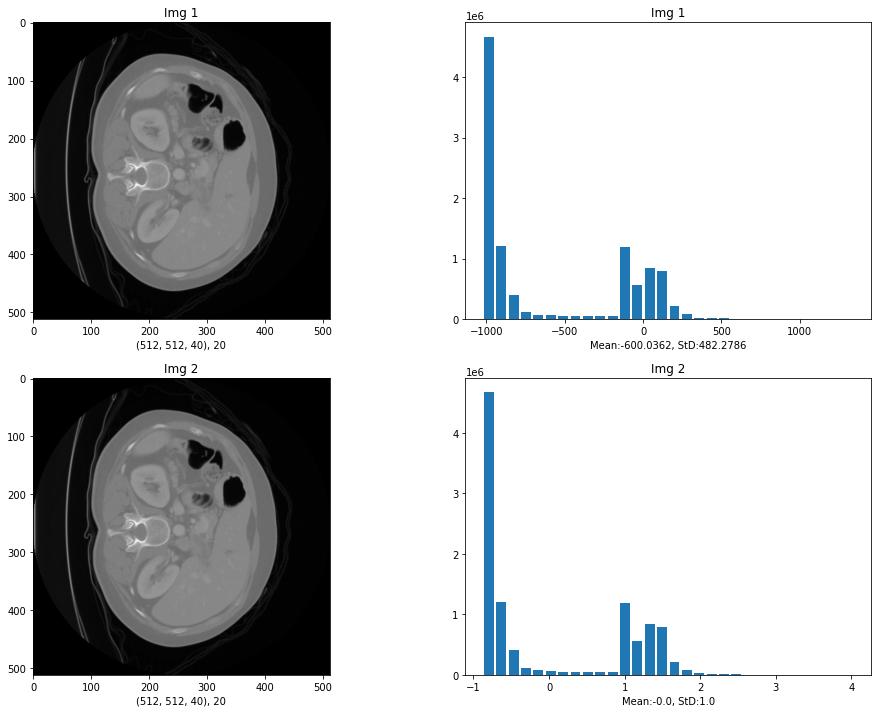

In [15]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.NormalizeIntensityd(keys, )])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.ScaleIntensityRanged**
Apply specific intensity scaling to the whole numpy array. Scaling from [a_min, a_max] to [b_min, b_max] with clip option.

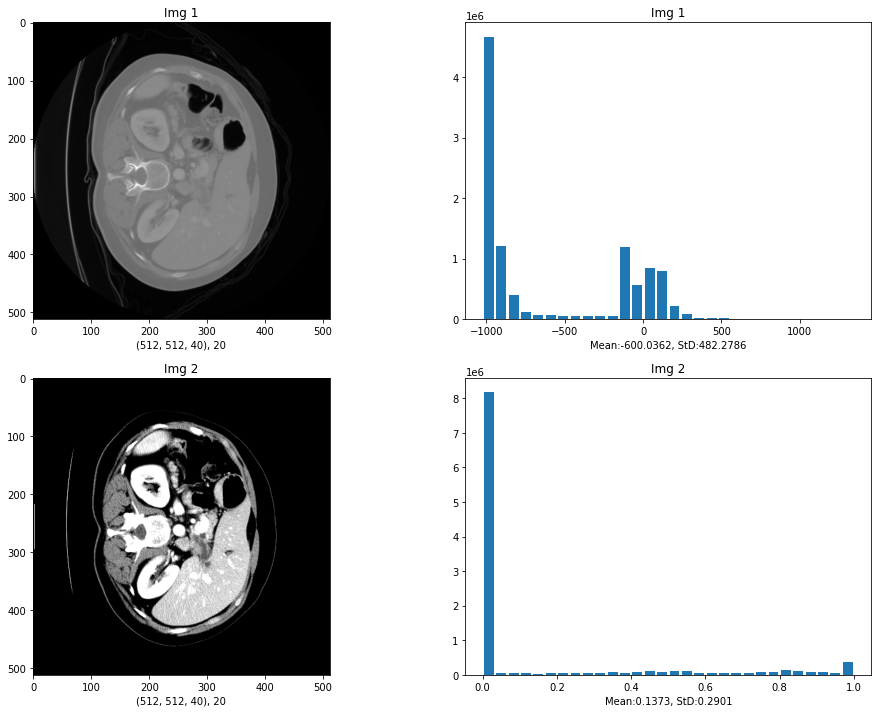

In [16]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                        a_min=-57, a_max=164,
                                                                        b_min=0.0, b_max=1.0),])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.GaussianSmoothd**
Apply Gaussian smooth to the input data based on specified sigma parameter

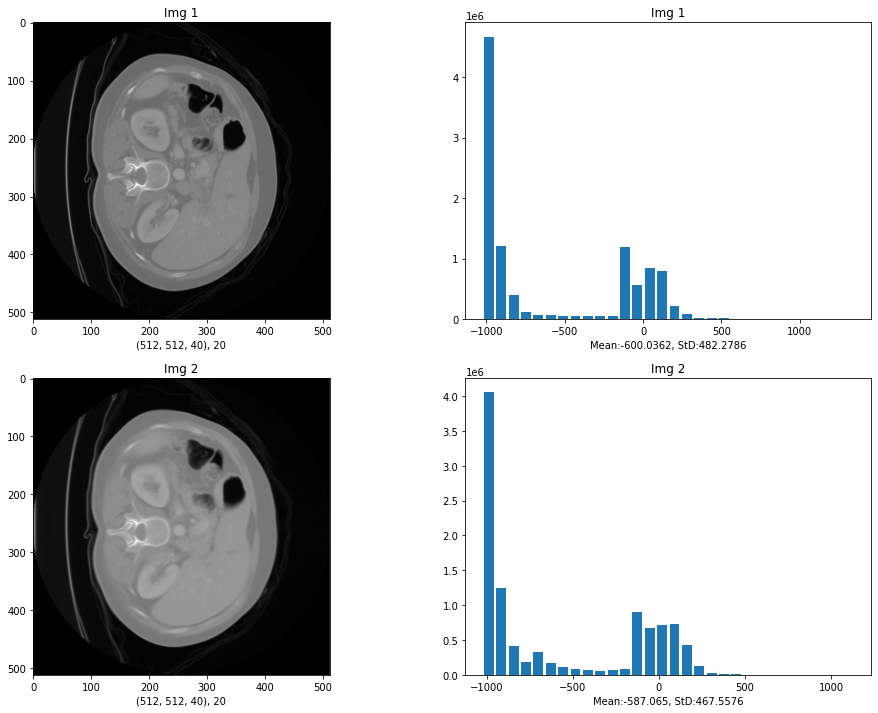

In [17]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.GaussianSmoothd(keys, sigma=1.)])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.HistogramNormalized**
Apply the histogram normalization to input image.

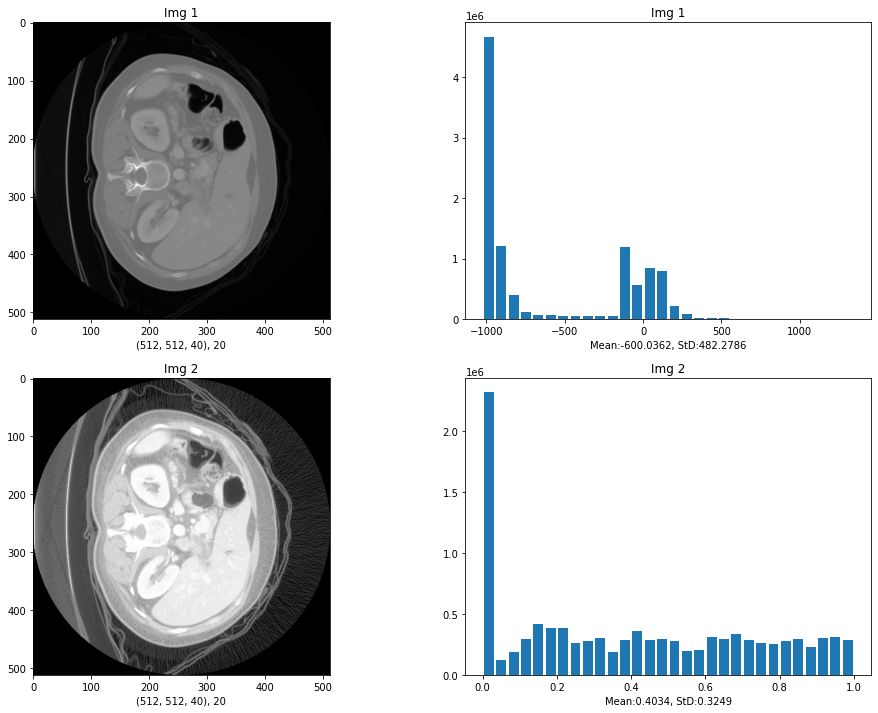

In [18]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),  
                                  monai.transforms.HistogramNormalized(keys, min=0, max=1)])

plot_trans_imgs_hist(trans_original, trans, data[0])

#### Spatial
- monai.transforms.SpatialPadd
- monai.transforms.SpatialCropd
- monai.transforms.CropForegroundd
- monai.transforms.Spacingd
- monai.transforms.Resized

##### **monai.transforms.SpatialPadd**
Performs padding to the data, symmetric for all sides or all on one side for each dimension.

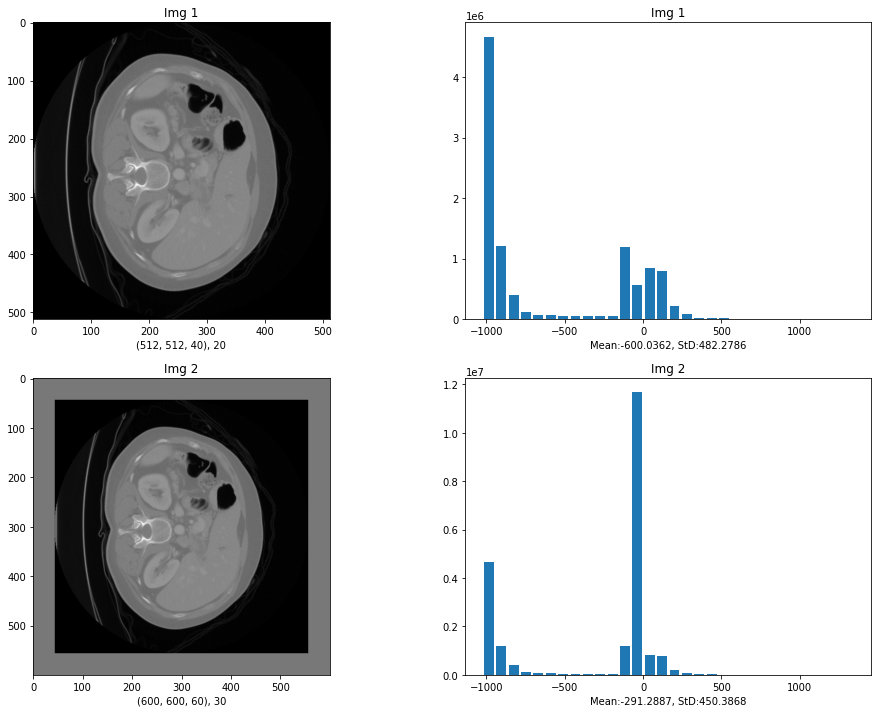

In [19]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.SpatialPadd(keys, spatial_size=(600, 600, 60), method='symmetric')])

plot_trans_imgs_hist(trans_original, trans, data[0])

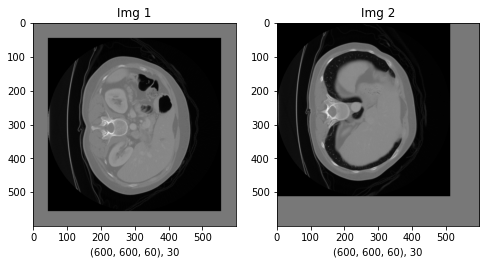

In [20]:
trans2 = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.SpatialPadd(keys, spatial_size=(600, 600, 60), method='end')])

plot_trans_imgs(trans, trans2, data[0])

##### **monai.transforms.SpatialCropd**
General purpose cropper to produce sub-volume region of interest.

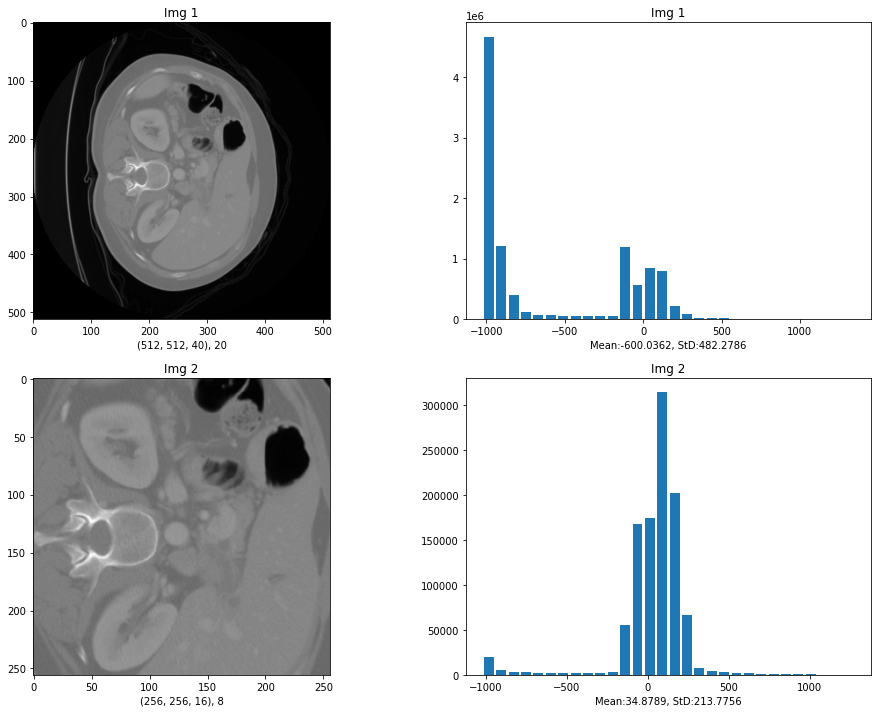

In [21]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.SpatialCropd(keys, roi_center=(256, 256, 20), roi_size=(256, 256, 16))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.CropForegroundd**
Crop only the foreground object of the expected images. The typical usage is to help training and evaluation if the valid part is small in the whole medical image. 

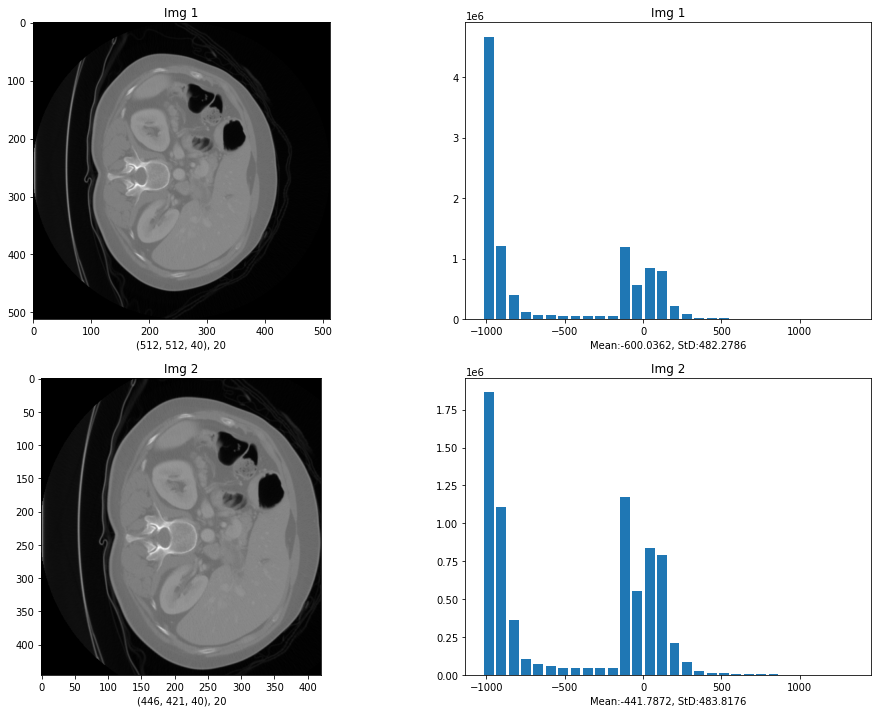

In [22]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.CropForegroundd(keys, source_key='img')])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.Spacingd**
Resample input image into the specified resolution pixdim (mm). 

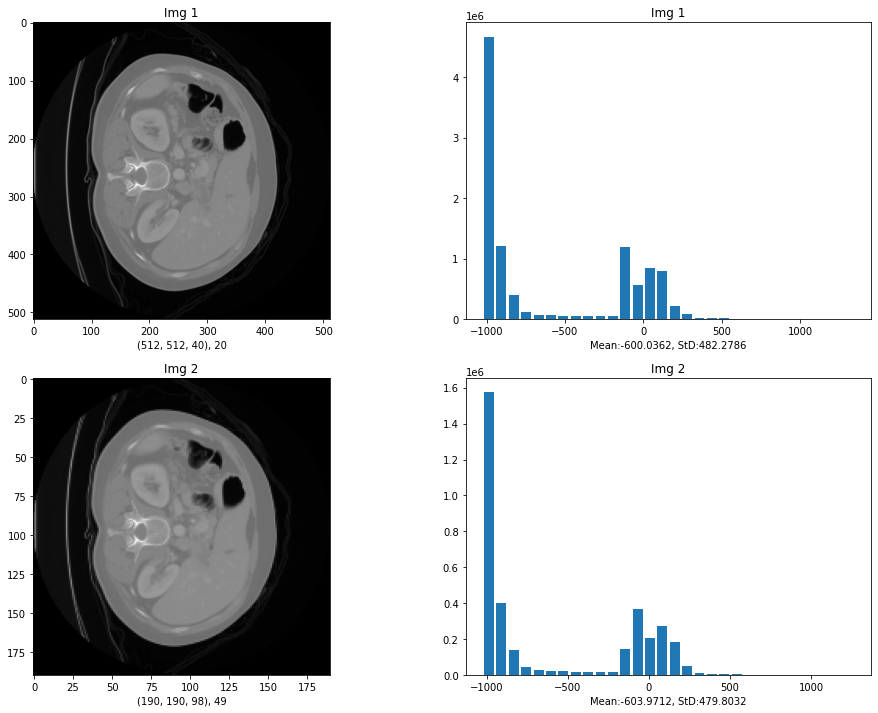

In [23]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.Spacingd(keys, pixdim=(2, 2, 2))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.Resized**
Resize the input image to given spatial size

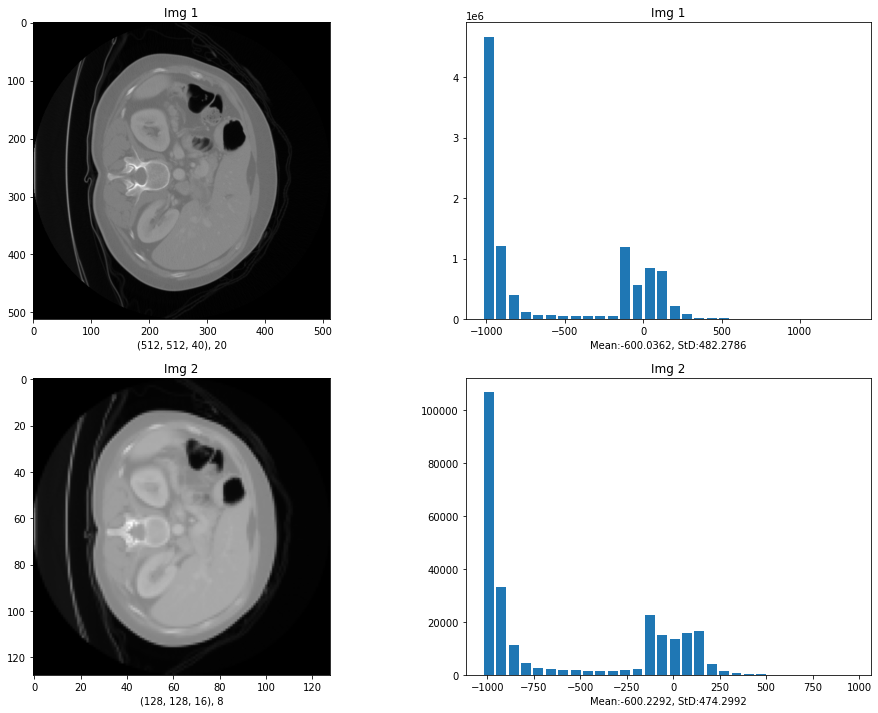

In [24]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.Resized(keys, spatial_size=(128, 128, 16))])

plot_trans_imgs_hist(trans_original, trans, data[0])

### ***Augmentation***
---

#### Intensity
- monai.transforms.RandGaussianNoised
- monai.transforms.RandStdShiftIntensityd
- monai.transforms.RandAdjustContrastd

##### **monai.transforms.RandGaussianNoised**
Add Gaussian noise to image with specified mean and std.

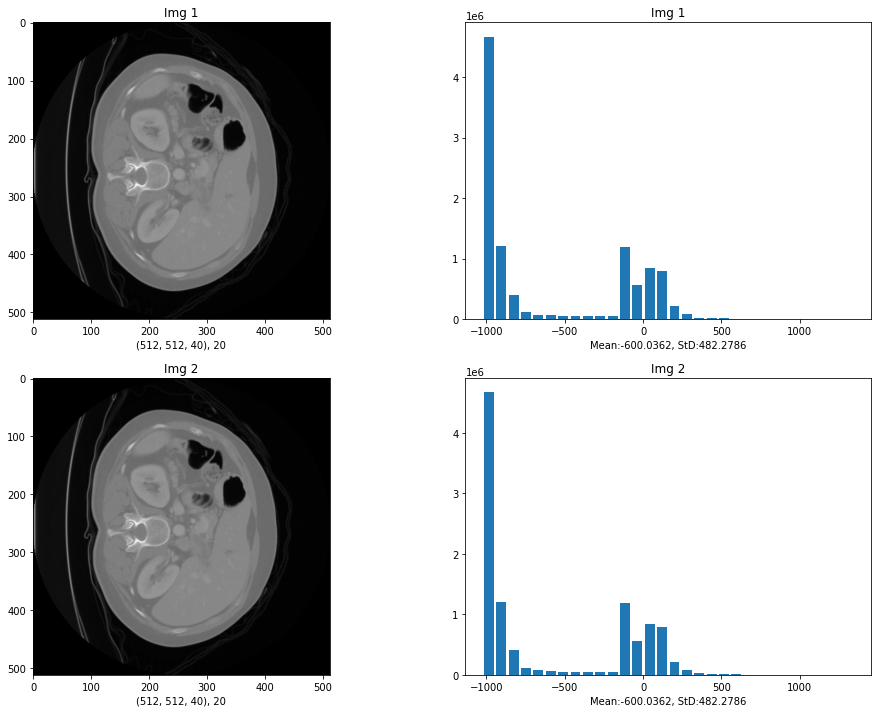

In [25]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.RandGaussianNoised(keys, prob=0.5, mean=0.0, std=200)])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandStdShiftIntensityd**
Randomly scale the intensity of input image by *v = v * (1 + factor)* where the factor is randomly picked.

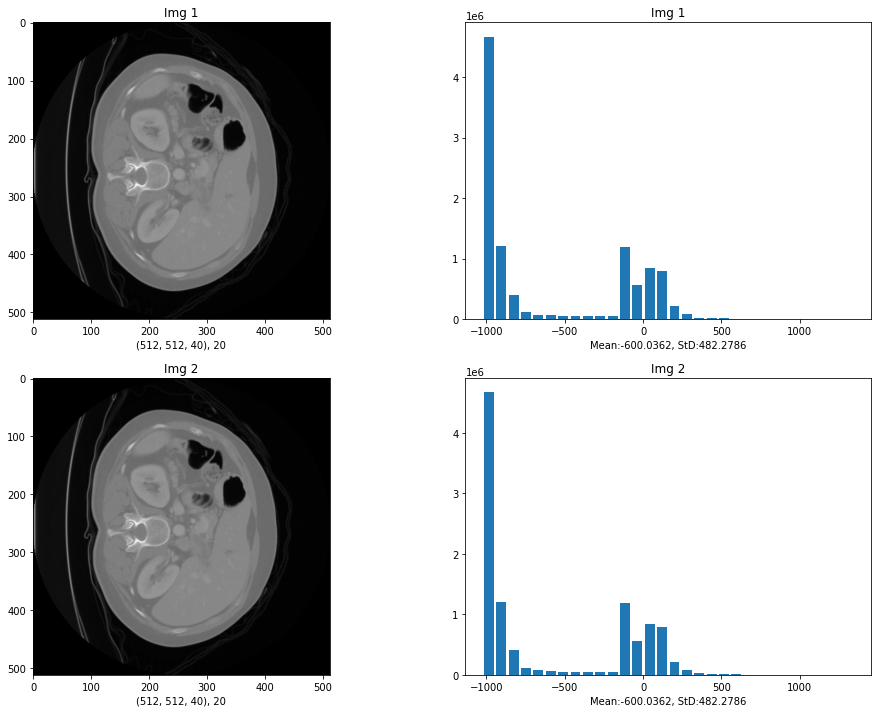

In [26]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.RandStdShiftIntensityd(keys, prob=0.5, factors=0.5, nonzero=False, channel_wise=True, )])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandAdjustContrastd**
Randomly changes image intensity by gamma. Each pixel/voxel intensity is updated as:
```
x = ((x - min) / intensity_range) ^ gamma * intensity_range + min
```

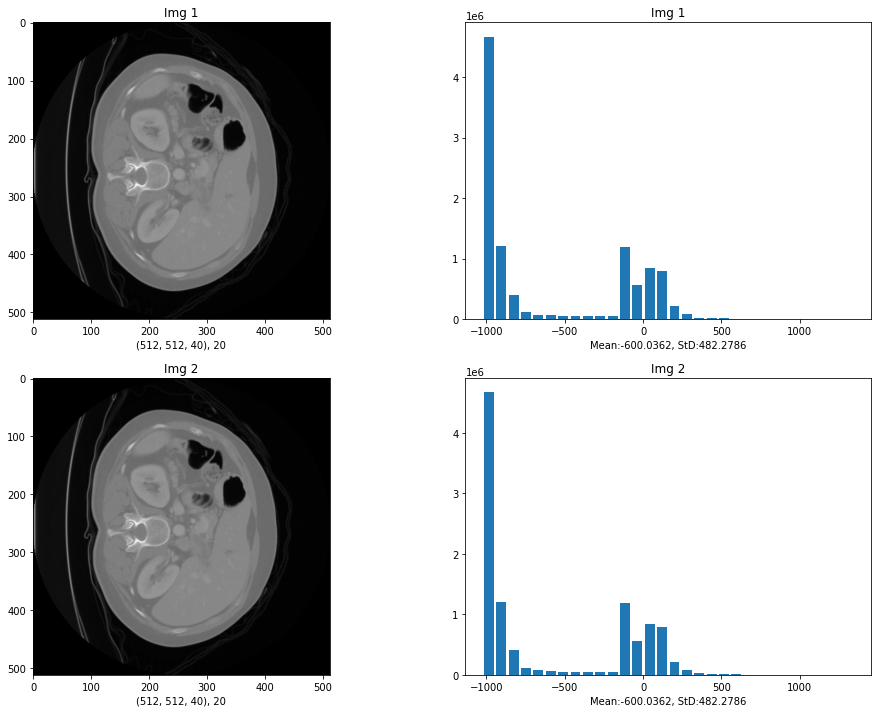

In [27]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.RandAdjustContrastd(keys, prob=0.5, gamma=(0.5, 4.5))])

plot_trans_imgs_hist(trans_original, trans, data[0])

#### Spatial
- monai.transforms.RandSpatialCropd
- monai.transforms.RandRotated
- monai.transforms.RandRotate90d
- monai.transforms.RandFlipd
- monai.transforms.RandGridDistortiond

##### **monai.transforms.RandSpatialCropd**
Crop image with random size or specific size ROI. It can crop at a random position as center or at the image center.

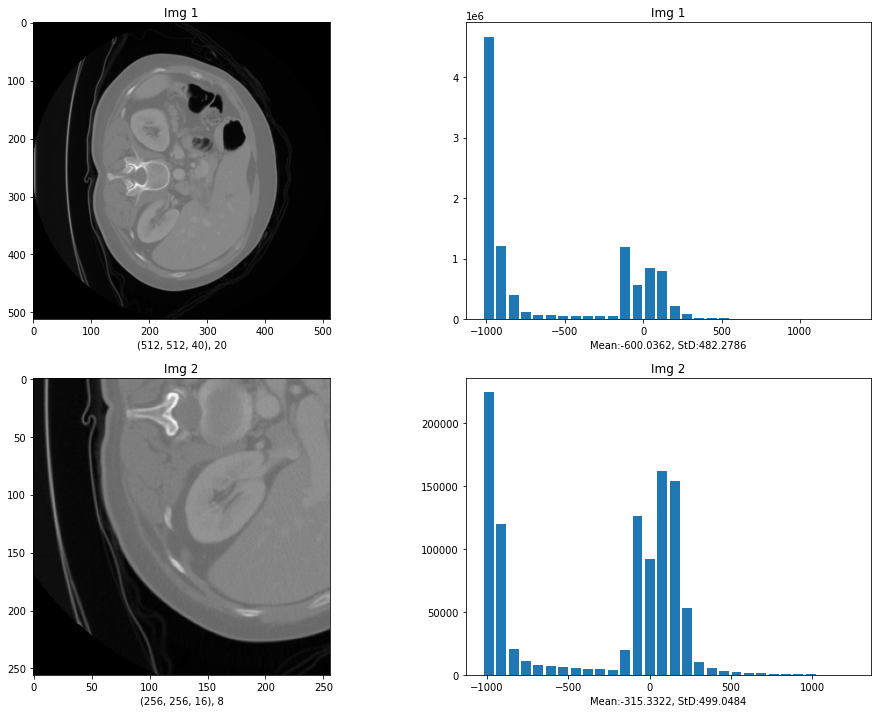

In [28]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandSpatialCropd(keys,
                                                                    roi_size=(256, 256, 16),
                                                                    random_center=True,
                                                                    random_size=False)])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandRotated**
Randomly rotate the input arrays for each axis.

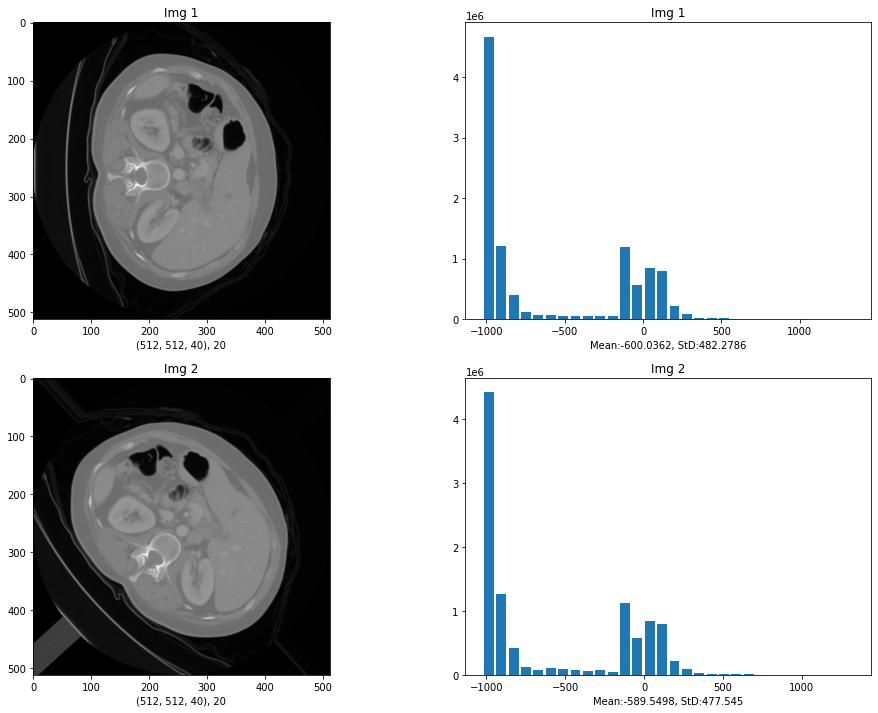

In [29]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandRotated(keys, prob=1., range_z=1., keep_size=True, )])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandRotate90d**
Input arrays are rotated by 90 degrees in the plane specified by spatial_axes

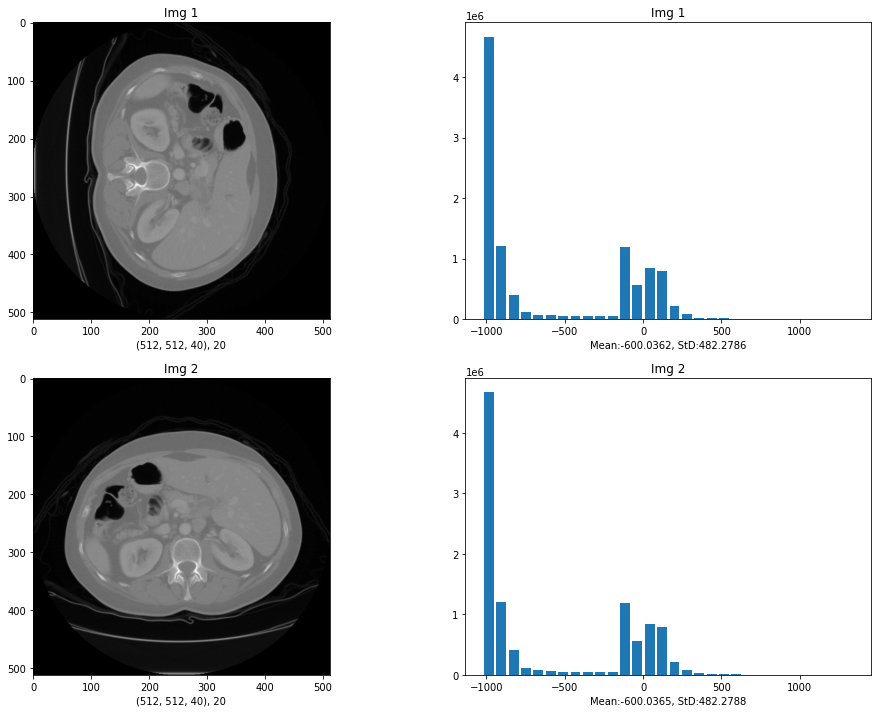

In [30]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandRotate90d(keys, prob=0.5, spatial_axes=(0, 1))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### **monai.transforms.RandFlip**
Randomly flips the image along axes.

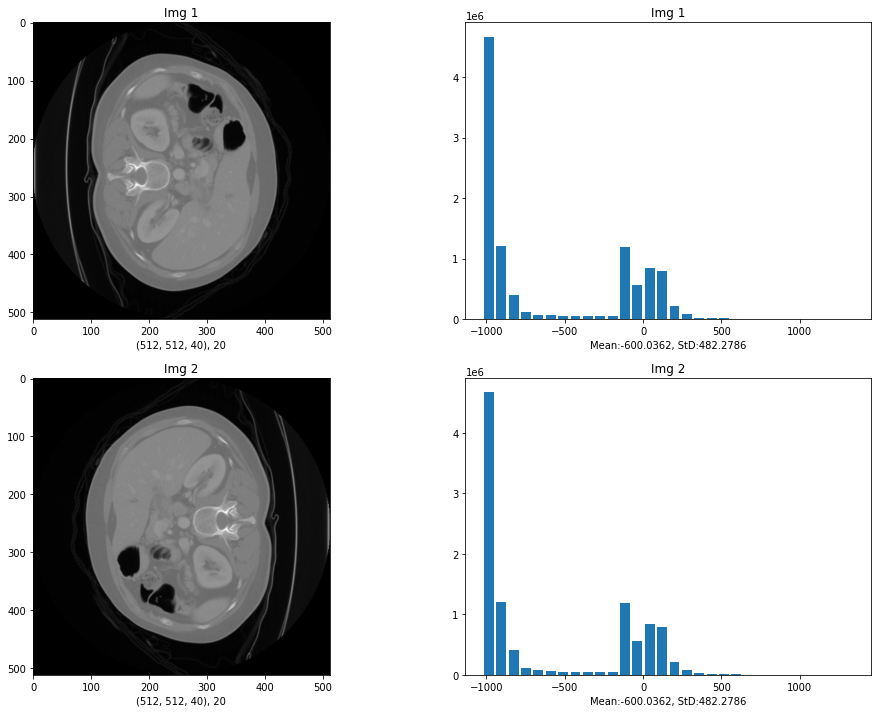

In [31]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandFlipd(keys, prob=0.5, spatial_axis=(0, 1))])

plot_trans_imgs_hist(trans_original, trans, data[0])

##### monai.transforms.RandGridDistortiond
Random grid distortion, refer to: https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

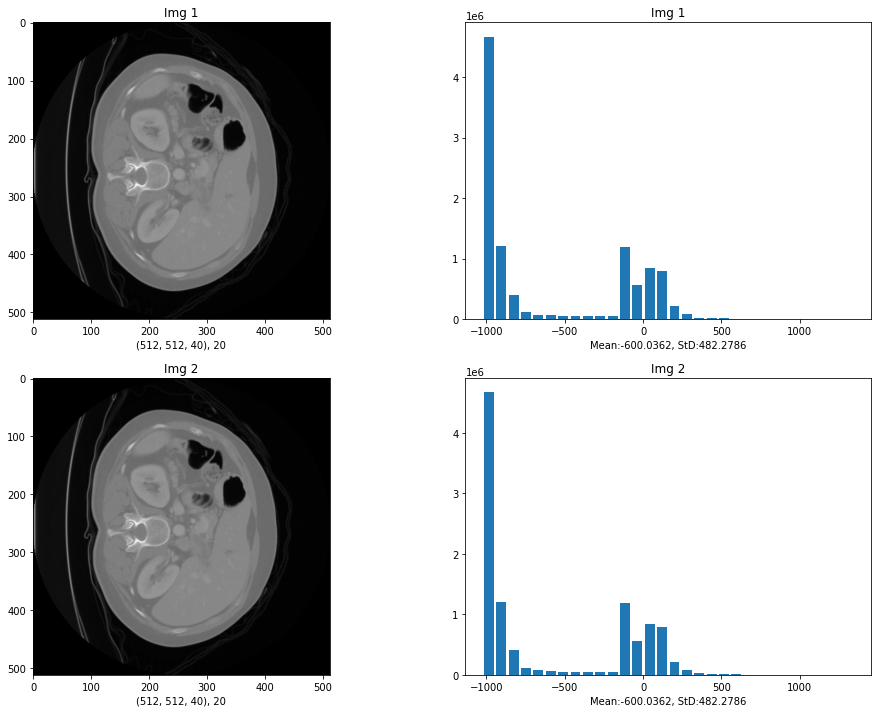

In [32]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.RandGridDistortiond(keys, prob=0.5, distort_limit=0.2)])

plot_trans_imgs_hist(trans_original, trans, data[0])

## GPU Accelerated Transforms

In [43]:
# Without GPU Accelerated

pre_trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys='img'),  
                                      monai.transforms.AddChanneld(keys='img'), 
                                      monai.transforms.Spacingd(keys='img', pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                      monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                            a_min=-57, a_max=164,
                                                                            b_min=0.0, b_max=1.0),
                                      monai.transforms.CropForegroundd(keys='img', source_key='img'),
                                      monai.transforms.RandSpatialCropd(keys='img', roi_size=(192, 192, 64)),
                                      monai.transforms.Resized(keys='img', spatial_size=[100, 100, 100]),
                                      monai.transforms.RandFlipd(keys='img', prob=1),
                                      monai.transforms.RandGaussianNoised(keys='img', prob=1, std=0.5),
                                      monai.transforms.ToTensord(keys='img')]) 

dataset = monai.data.CacheDataset(data, transform=pre_trans)

n = 20
t1 = time.time()
for i in range(n):
    for d in dataset:
        _ = d
t2 = time.time()
print(round((t2-t1)/n, 4))

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


0.0909


In [44]:
# With GPU Accelerated

pre_trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys='img'),  
                                      monai.transforms.AddChanneld(keys='img'),
                                      monai.transforms.ToTensord(keys='img', device='cuda'),
                                      monai.transforms.Spacingd(keys='img', pixdim=[1.5, 1.5, 2.0], mode='bilinear'),
                                      monai.transforms.ScaleIntensityRanged(keys='img', clip=True,
                                                                            a_min=-57, a_max=164,
                                                                            b_min=0.0, b_max=1.0),
                                      monai.transforms.CropForegroundd(keys='img', source_key='img'),
                                      monai.transforms.RandSpatialCropd(keys='img', roi_size=(192, 192, 64)),
                                      monai.transforms.Resized(keys='img', spatial_size=[100, 100, 100]),
                                      monai.transforms.RandFlipd(keys='img', prob=1),
                                      monai.transforms.RandGaussianNoised(keys='img', prob=1, std=0.5)]) 

dataset = monai.data.CacheDataset(data, transform=pre_trans)

n = 20
t1 = time.time()
for i in range(n):
    for d in dataset:
        _ = d
t2 = time.time()
print(round((t2-t1)/n, 4))

Loading dataset: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


0.0409
